# MultiVisit Analysis of HD106315b

We have analysed two visits of HD106315 individually -- now we will use `pycheops.MultiVisit` to analyse both of the visits simultaneously.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from dace.cheops import Cheops
import pycheops
from uncertainties import ufloat
from uncertainties.umath import sqrt as usqrt
import lmfit as lmf
import re
from pycheops.utils import phaser

Let's load the saved datasets using `MultiVisit` class.

In [2]:
M = pycheops.MultiVisit('HD 106315', ident='none')


 N  file_key                   Aperture last_ GP  Glint pipe_ver
 ---------------------------------------------------------------------------
  1 CH_PR100041_TG000802_V0200 OPTIMAL  lmfit No  Yes   13.1.0
  2 CH_PR100041_TG001401_V0200 OPTIMAL  lmfit No  Yes   13.1.0


In [3]:
rprs = np.random.normal(0.01728, 0.0006, 10000)
dep, dep_err = np.mean((rprs**2)*1e6), np.std((rprs**2)*1e6)

"""
star = pycheops.StarProperties(dd.target)
print(star)
"""
teff = np.random.normal(6277, 51.5, 10000)
logg = np.random.normal(4.25, 0.02, 10000)
mh = np.random.normal(-0.22, 0.07, 10000)
h1, h2 = np.zeros(10000), np.zeros(10000)
cdc = pycheops.ld.stagger_power2_interpolator('CHEOPS')
for i in range(len(teff)):
    c1, c2, h1[i], h2[i] = cdc(teff[i], logg[i], mh[i])

Now, to fit for TTVs, we need to fix T_0 (transit central times). We can take the same from our previous analysis of `MultiFit` (or, we can do another analysis <i>without</i> including TTVs and take T_0 from there).

In [4]:
TJD_0 = M.tzero(2457586.5267, 9.55237)
result = M.fit_transit(unroll=True, nroll=1, ttv=True, ttv_prior=500, P=9.55237000, T_0=1952.49833,
                       extra_priors={
                           'logrho':ufloat(-0.229,0.045)},
                       burn=1024, steps=512, nwalkers=256)

Running burn-in ..


100%|██████████| 1024/1024 [12:35<00:00,  1.35it/s]

Running sampler ..



100%|██████████| 512/512 [06:13<00:00,  1.37it/s]


In [5]:
print(M.fit_report(min_correl=0.8))

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 416380
    # data points      = 3376
    # variables        = 16
    chi-square         = 6358.55242
    reduced chi-square = 1.89242632
    Akaike info crit   = -44794.6839
    Bayesian info crit = -44696.6928
    RMS residual       = 323.2 ppm
[[Variables]]
    D:               2.9183e-04 +/- 1.7392e-05 (5.96%) (init = 0.0003098181)
    W:               0.01663609 +/- 5.7672e-04 (3.47%) (init = 0.01518939)
    b:               0.58500886 +/- 0.05816463 (9.94%) (init = 0.6758056)
    P:               9.55237 (fixed)
    T_0:             1952.498 (fixed)
    f_c:             0 (fixed)
    f_s:             0 (fixed)
    h_1:             0.7686309 (fixed)
    h_2:             0.4615763 (fixed)
    k:               0.01708289 == 'sqrt(D)'
    aR:              15.9192101 == 'sqrt((1+k)**2-b**2)/W/pi'
    sini:            0.99932454 == 'sqrt(1 - (b/aR)**2)'
    logrho:         -0.22677104 == 'log10(4.3275e-4*((1+k)**

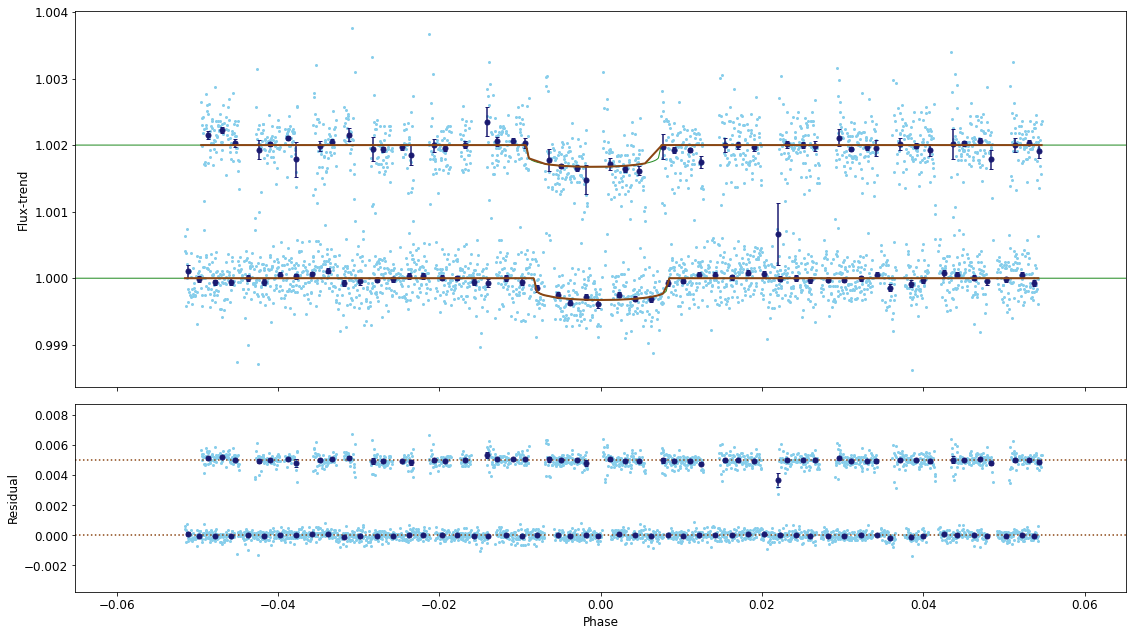

In [6]:
M.plot_fit(binwidth=0.002, data_offset=0.002, res_offset=0.005, detrend=True, figsize=(16,9));

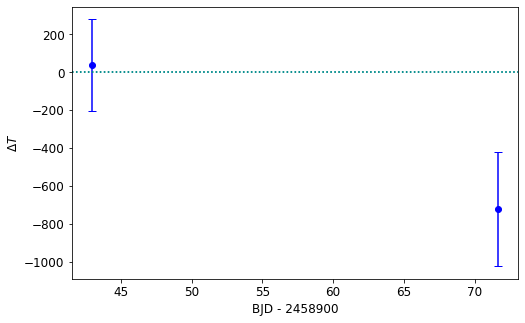

In [7]:
M.ttv_plot();

Well, I do not think that we have find any evidence for the TTVs.

## Trend of Roll-Anlge with time

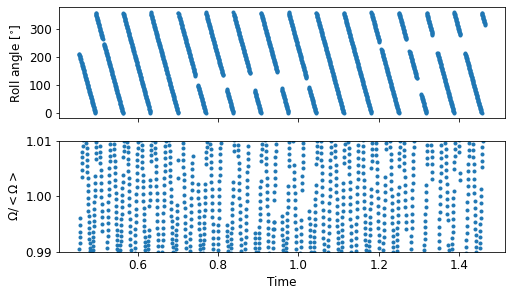

In [8]:
fig,ax = plt.subplots(figsize=(8,4.5),nrows=2,sharex=True)
t = M.datasets[0].lc['time']
t0 = np.floor(t[0])
roll_angle = M.datasets[0].lc['roll_angle']
ax[0].plot(t-t0,roll_angle,'.')
ax[0].set_ylabel('Roll angle [$^{\circ}$]')
drdt = np.gradient(roll_angle)
Omega = np.nanmedian(drdt)
ax[1].plot(t-t0,drdt/Omega,'.')
ax[1].set_ylim(0.99,1.01)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('$\Omega/<\Omega>$');

Wow! The variations can be indeed high! We can remove this correlations as follows:

 - We can either ignore it (only if trends are not large)
 - We can increase nroll (upto which harmonics of roll angle we want to include in decorrelation)
 - Or we can remove the prior decorrelation first and then fit for it (using `unwrap=True`).

In [9]:
result = M.fit_transit(unroll=True, nroll=1, unwrap=True, ttv=True, ttv_prior=500, P=9.55237000, T_0=1952.49833,
                       extra_priors={
                           'logrho':ufloat(-0.229,0.045)},
                       burn=1024, steps=512, nwalkers=256)

Running burn-in ..


100%|██████████| 1024/1024 [12:45<00:00,  1.34it/s]

Running sampler ..



100%|██████████| 512/512 [06:10<00:00,  1.38it/s]


In [10]:
print(M.fit_report(min_correl=0.8))

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400481
    # data points      = 3376
    # variables        = 16
    chi-square         = 7202.97140
    reduced chi-square = 2.14374149
    Akaike info crit   = -44916.6437
    Bayesian info crit = -44818.6526
    RMS residual       = 329.1 ppm
[[Variables]]
    D:               2.9216e-04 +/- 1.5887e-05 (5.44%) (init = 0.0003098181)
    W:               0.01667821 +/- 4.3834e-04 (2.63%) (init = 0.01518939)
    b:               0.58207374 +/- 0.04982494 (8.56%) (init = 0.6758056)
    P:               9.55237 (fixed)
    T_0:             1952.498 (fixed)
    f_c:             0 (fixed)
    f_s:             0 (fixed)
    h_1:             0.7686309 (fixed)
    h_2:             0.4615763 (fixed)
    k:               0.01709273 == 'sqrt(D)'
    aR:              15.9184784 == 'sqrt((1+k)**2-b**2)/W/pi'
    sini:            0.99933124 == 'sqrt(1 - (b/aR)**2)'
    logrho:         -0.22683092 == 'log10(4.3275e-4*((1+k)**

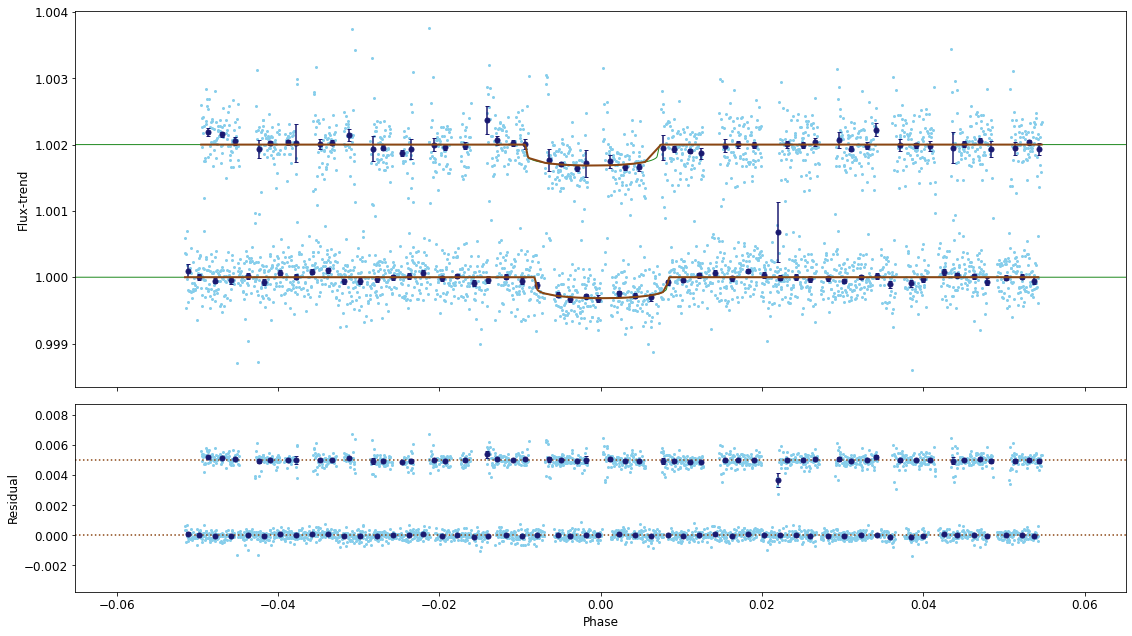

In [11]:
M.plot_fit(binwidth=0.002, data_offset=0.002, res_offset=0.005, detrend=True, figsize=(16,9));

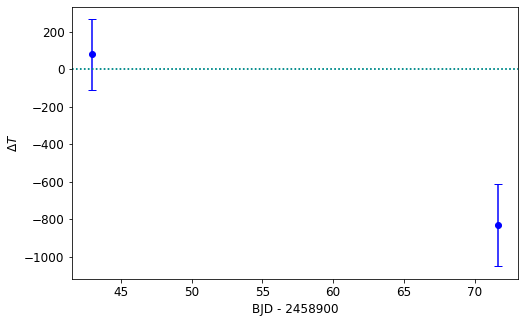

In [12]:
M.ttv_plot();

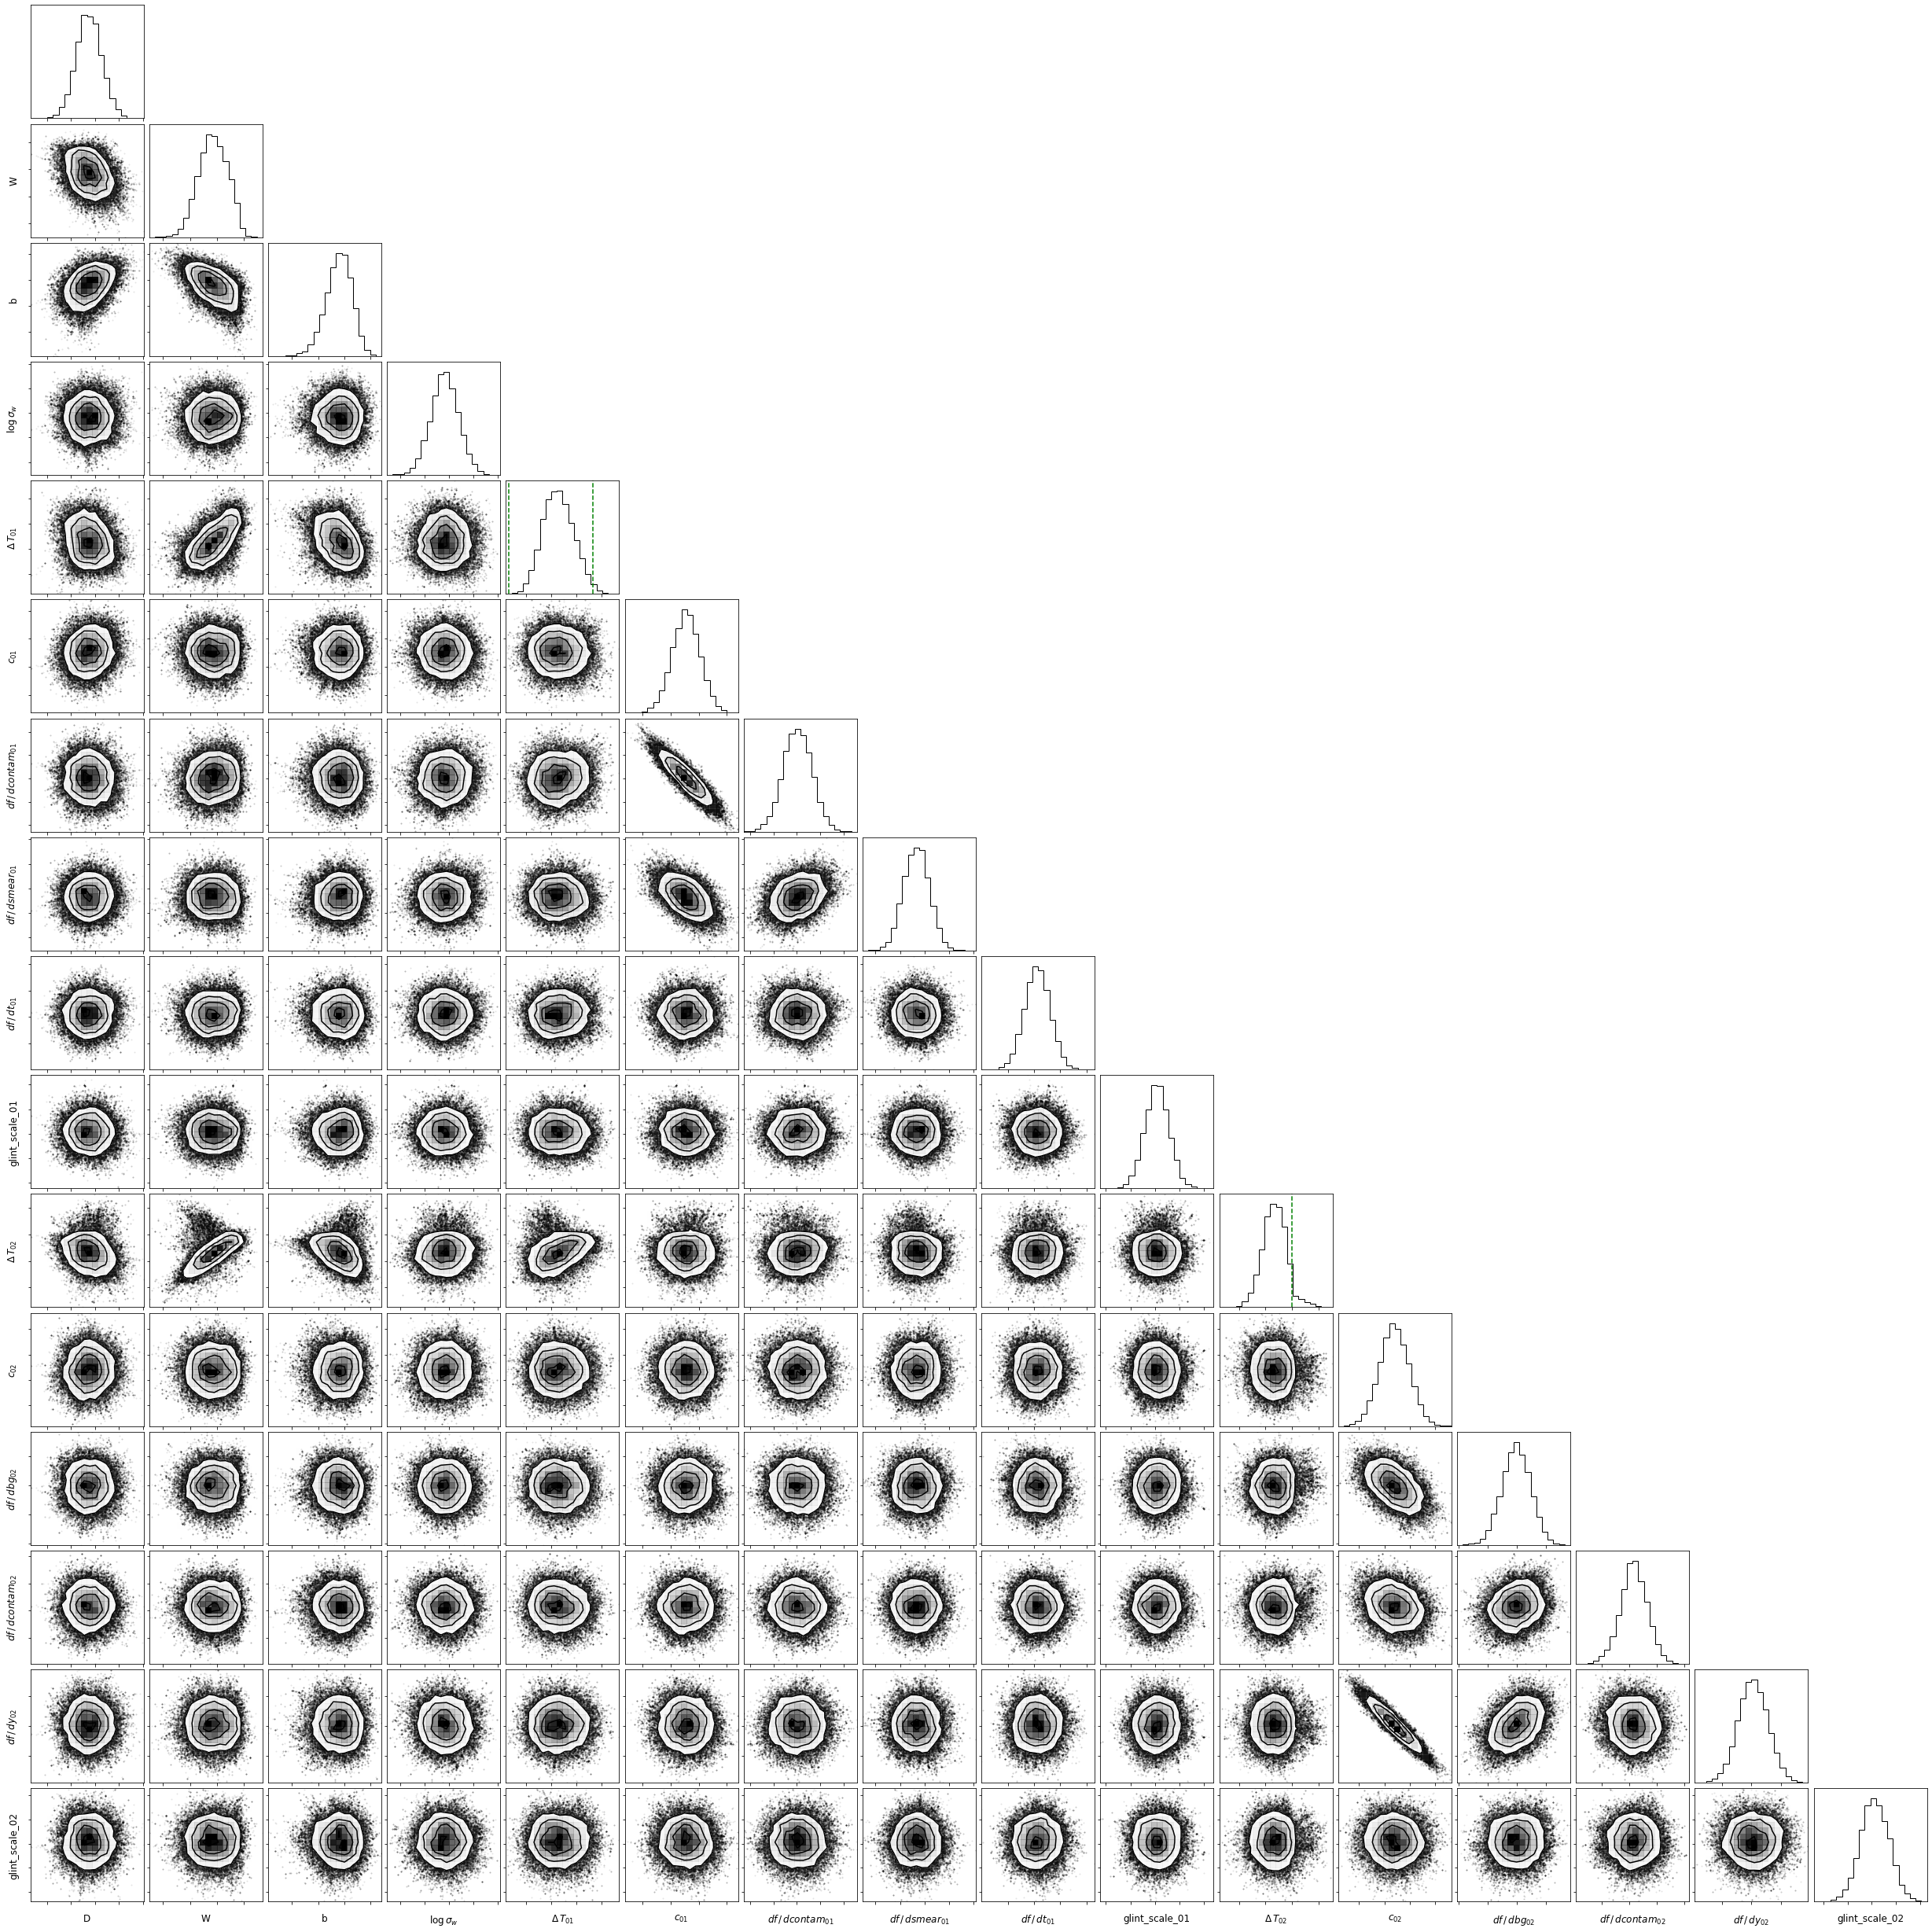

In [13]:
M.corner_plot(plotkeys='all');

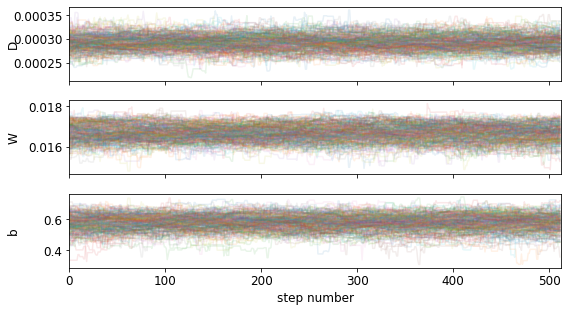

In [14]:
M.trail_plot();

In [15]:
result.params

Parameters([('D',
             <Parameter 'D', value=0.00029216152323498527 +/- 1.59e-05, bounds=[7.467204992673676e-05:0.001195968202855694]>),
            ('W',
             <Parameter 'W', value=0.016678213200356746 +/- 0.000438, bounds=[0.004116675504160253:0.06586680806656404]>),
            ('b',
             <Parameter 'b', value=0.5820737431242557 +/- 0.0498, bounds=[0:1]>),
            ('P', <Parameter 'P', value=9.55237 (fixed), bounds=[0:inf]>),
            ('T_0',
             <Parameter 'T_0', value=1952.49833 (fixed), bounds=[-inf:inf]>),
            ('f_c', <Parameter 'f_c', value=0.0 (fixed), bounds=[-1:1]>),
            ('f_s', <Parameter 'f_s', value=0.0 (fixed), bounds=[-1:1]>),
            ('h_1',
             <Parameter 'h_1', value=0.7686308585941712 (fixed), bounds=[0:1]>),
            ('h_2',
             <Parameter 'h_2', value=0.4615762712077681 (fixed), bounds=[0:1]>),
            ('k',
             <Parameter 'k', value=0.017092733053405626, bounds=[0:1], expr='sqrt(D)'>),
            ('aR',
             <Parameter 'aR', value=15.91847839841706, bounds=[1:inf], expr='sqrt((1+k)**2-b**2)/W/pi'>),
            ('sini',
             <Parameter 'sini', value=0.9993312432776934, bounds=[-inf:inf], expr='sqrt(1 - (b/aR)**2)'>),
            ('logrho',
             <Parameter 'logrho', value=-0.22683092010684794, bounds=[-9:6], expr='log10(4.3275e-4*((1+k)**2-b**2)**1.5/W**3/P**2)'>),
            ('e',
             <Parameter 'e', value=0.0, bounds=[0:1], expr='f_c**2 + f_s**2'>),
            ('q_1',
             <Parameter 'q_1', value=0.28990011172653085, bounds=[0:1], expr='(1-h_2)**2'>),
            ('q_2',
             <Parameter 'q_2', value=0.570284277914672, bounds=[0:1], expr='(h_1-h_2)/(1-h_2)'>),
            ('log_sigma_w',
             <Parameter 'log_sigma_w', value=-8.50896517872307 +/- 0.028, bounds=[-12:-2]>),
            ('ttv_01',
             <Parameter 'ttv_01', value=78.61747479205299 +/- 187, bounds=[-inf:inf]>),
            ('c_01',
             <Parameter 'c_01', value=0.9999418122214065 +/- 1.99e-05, bounds=[0.4992974725158192:2.0026406988358256]>),
            ('dfdcontam_01',
             <Parameter 'dfdcontam_01', value=-0.00017869673347461394 +/- 3.68e-05, bounds=[-inf:inf]>),
            ('dfdsmear_01',
             <Parameter 'dfdsmear_01', value=9.986328658953361e-05 +/- 3.13e-05, bounds=[-inf:inf]>),
            ('dfdt_01',
             <Parameter 'dfdt_01', value=-0.00014424042144110653 +/- 2.38e-05, bounds=[-inf:inf]>),
            ('glint_scale_01',
             <Parameter 'glint_scale_01', value=1.0194005474834278 +/- 0.123, bounds=[0:2]>),
            ('ttv_02',
             <Parameter 'ttv_02', value=-833.1816310928004 +/- 219, bounds=[-inf:inf]>),
            ('c_02',
             <Parameter 'c_02', value=1.000338499861596 +/- 5.83e-05, bounds=[0.4986410371096393:2.002927380144693]>),
            ('dfdbg_02',
             <Parameter 'dfdbg_02', value=-0.0018036059174387617 +/- 7.24e-05, bounds=[-inf:inf]>),
            ('dfdcontam_02',
             <Parameter 'dfdcontam_02', value=0.0003165199673485441 +/- 4.86e-05, bounds=[-inf:inf]>),
            ('dfdy_02',
             <Parameter 'dfdy_02', value=-0.000292849786897063 +/- 7.46e-05, bounds=[-inf:inf]>),
            ('glint_scale_02',
             <Parameter 'glint_scale_02', value=1.011213027836783 +/- 0.0595, bounds=[0:2]>)])